# Image Loading and Preprocessing

In this tutorial we're going to look at how we can load in images from a local file or a URL which you can then utilize in other tutorials or examples. Also, we're going to go in depth on the kinds of preprocessing that is necessary to utilize Caffe2 with images.

#### Mac OSx Prerequisites

Install OpenCV. Also...

```
sudo pip install scikit-image scipy matplotlib
```
TODO: lighter-weight way for image handling?

In [1]:
%matplotlib inline
import skimage
import skimage.io as io
import skimage.transform 
import sys
import numpy as np
import math
from matplotlib import pyplot
#from IPython import display
import matplotlib.image as mpimg
import cv2
print("Required modules imported.")

Required modules imported.


## Test an Image

In the code block below use IMAGE_LOCATION to load what you would like to test. Just change the comment flags to go through each round of the Tutorial. In this way, you'll get to see what happens with a variety of image formats and some tips on how you might preprocess them. If you want to try your own image, drop it in the images folder or use a remote URL. When you pick a remote URL, make it easy on yourself and try to find a URL that points to a common image file type and extension versus some long identifier or query string which might just break this next step.

## Color Issues

Keep in mind when you load images from smartphone cameras that you may run into color formatting issues. Below we show an example of how flipping between RGB and BGR can impact an image. This would obviously throw off detection in your model. Make sure the image data you're passing around is what you think it is!

### Caffe Uses BGR Order

Due to legacy support of OpenCV in Caffe and how it handles images in Blue-Green-Red (BGR) order instead of the more commonly used Red-Green-Blue (RGB) order, Caffe2 also expects **BGR** order. In many ways this decision helps in the long run as you use different computer vision utilities and libraries, but it also can be the source of confusion. 

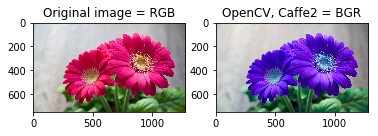

In [2]:
# You can load either local IMAGE_FILE or remote URL
# For Round 1 of this tutorial, try a local image.
#IMAGE_LOCATION = 'images/cat.jpg'

# For Round 2 of this tutorial, try a URL image with a flower: 
IMAGE_LOCATION = "https://cdn.pixabay.com/photo/2015/02/10/21/28/flower-631765_1280.jpg"

# For Round 3 of this tutorial, try another URL image with lots of people:
#IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/1/18/NASA_Astronaut_Group_15.jpg"

# For Round 4 of this tutorial, try a URL image with a portrait!
#IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/9/9a/Ducreux1.jpg"

img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)

# test color reading
# show the original image
pyplot.figure()
pyplot.subplot(1,2,1)
pyplot.imshow(img)
pyplot.axis('on')
pyplot.title('Original image = RGB')

# show the image in BGR
#pyplot.figure()
pyplot.subplot(1,2,2)
# TODO: would like to remove opencv but still use this kind of BGR example
imgBGR = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pyplot.imshow(imgBGR)
pyplot.axis('on')
pyplot.title('OpenCV, Caffe2 = BGR')

As you can see in the example above, the difference in order is very important to keep in mind. In the code block below we'll be taking the image and converting to BGR order for Caffe to process it appropriately.

But wait, there's more color fun...

### Caffe Prefers CHW Order

Now what!? What's CHW, you ask? Well, there's also HWC! Both formats come up in image processing.

- H: Height
- W: Width
- C: Channel (as in color)

Digging even deeper into how image data can be stored is the memory allocation order. You might have noticed when we first loaded the image that we forced it through some interesting transformations. These were data transformations that let us play with the image as if it were a cube. What we see is on top of the cube, and manipulating the layers below can change what we view. We can tinker with it's underlying properties and as you saw above, swap colors quite easily. 

For GPU processing, which is what Caffe2 excels at, this order needs to be CHW. For CPU processing, this order is generally HWC. Essentially, you're going to want to use CHW and make sure that step is included in your image pipeline. Tweak RGB to be BGR, which is encapsulated as this "C" payload, then tweak HWC, the "C" being the very same colors you just switched around.

You may ask why! And the reason points to cuDNN which is what helps accelerate processing on GPUs. It uses only CHW, and we'll sum it up by saying it is faster. 

Give these two transformations, you might think that's enough, but it isn't. We still need to resize and/or crop and potentially look at things like orientation (rotation) and mirroring.

## Rotation and Mirroring

This topic is usually reserved for images that are coming from a smart phone. Phones, in general, take great pictures, but do a horrible job communicating how the image was taken and what orientation it should be in. Then there's the user who does everything under the sun with their phone's cameras, making them do things its designer never expected. Cameras - right, because there are often two cameras and these two cameras take different sized pictures in both pixel count and aspect ratio, and not only that, they sometimes take them mirrored, and they sometimes take them in portrait and landscape modes, and sometimes they don't bother to tell which mode they were in. 

In many ways this is the first thing you need to evaluate in your pipeline, then look at sizing (described below), then figure out the color situation. If you're developing for iOS, then you're in luck, it's going to be relatively easy. If you're a super-hacker wizard developer with lead-lined shorts and developing for Android, then at least you have lead-lined shorts. 

The variability in the Android marketplace is wonderful and horrifying. In an ideal world, you could rely on the EXIF data in pictures coming from any camera and use that to decide orientation and mirroring and you'd have one simple case function to handle your transformations. No such luck, but you're not alone. Many have come before you and suffered for you.

### Library for Handling Mobile Images

Hooray! We're going to give you something to ease your pain. These are not full-proof. Users can and will defy you and every other developers' best attempts to handle their images. Here we'll link to some resources that can be used depending on the platform.

Image Preprocessing Libraries and/or Snippits
- [iOS](#)
- [Android](#)
- [Python](#)
In the meantime though, let's play with some images and show the basics for manipulations that you might need to do.

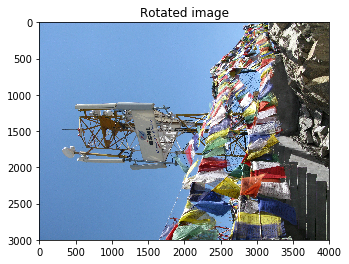

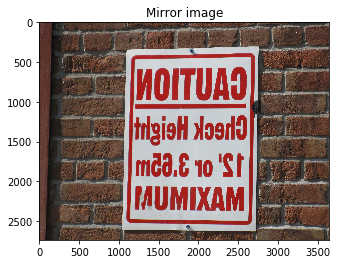

In [20]:
# Image came in sideways - it should be a portait image!
# How you detect this depends on the platform
# Could be a flag from the camera object
# Could be in the EXIF data
ROTATED_IMAGE = "https://upload.wikimedia.org/wikipedia/commons/8/87/Cell_Phone_Tower_in_Ladakh_India_with_Buddhist_Prayer_Flags.jpg"
imgRotated = skimage.img_as_float(skimage.io.imread(ROTATED_IMAGE)).astype(np.float32)
pyplot.figure()
pyplot.imshow(imgRotated)
pyplot.axis('on')
pyplot.title('Rotated image')

# Image came in flipped or mirrored - text is backwards!
# Again detection depends on the platform
# This one is intended to be read by drivers in their rear-view mirror
MIRROR_IMAGE = "https://upload.wikimedia.org/wikipedia/commons/2/27/Mirror_image_sign_to_be_read_by_drivers_who_are_backing_up_-b.JPG"
imgMirror = skimage.img_as_float(skimage.io.imread(MIRROR_IMAGE)).astype(np.float32)
pyplot.figure()
pyplot.imshow(imgMirror)
pyplot.axis('on')
pyplot.title('Mirror image')

So you can see that we kind of have some problems. If we're detecting places, landmarks, or objects, a sideways cell tower is no good. If we're detecting text and doing automatic language translation, then mirrored text is no good. But hey, maybe you want to make a model that can detect English both ways. That would be awesome, but not for this tutorial!

Let's transform these babies into something Caffe2 and the standard detection models we have around can detect. Also, this little trick might save you if, say for example, you really had to detect the cell tower but there's no EXIF data to be found: then you'd cycle through every rotation, and every flip, spawning many derivatives of this photo and run them all through. When the percentage of confidence of detection is high enough, Bam!, you found the orientation you needed and that sneaky cell tower.

Anyway, to the example code:

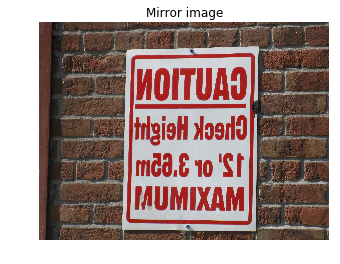

In [27]:
# Run me to flip the image back and forth
imgMirror = np.fliplr(imgMirror)
pyplot.figure()
pyplot.imshow(imgMirror)
pyplot.axis('off')
pyplot.title('Mirror image')

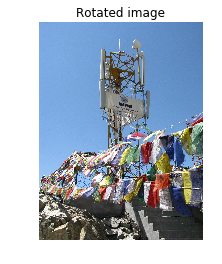

In [32]:
# Run me to rotate the image 90 degrees
imgRotated = np.rot90(imgRotated)
pyplot.figure()
pyplot.imshow(imgRotated)
pyplot.axis('off')
pyplot.title('Rotated image')

## Sizing

Part of preprocessing is resizing. For reasons we won't get into here, images in the Caffe2 pipeline should be square. Also, to help with performance, they should be resized to a standard height and width which is usually going to be smaller than your original source. In the example below we're resizing to 256 x 256 pixels, however you might notice that the `input_height` and `input_width` is set to 224 x 224 which is then used to specify the crop. This is what several image-based models are expecting. They were trained on images sized to 224 x 224 and in order for the model to properly identify the suspect images you throw at it, these should also be 224 x 224.

** Make sure you double-check the input sizes for the model you're using!**

Model's input shape is 224x224
New image shape:(256, 256, 3)


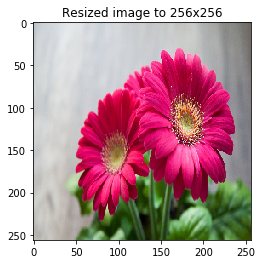

In [29]:
# Model is expecting 224 x 224, so resize/crop needed.
# Here are the steps we use to preprocess the image.
# (1) Resize the image to 256*256, and crop out the center.
input_height, input_width = 224, 224
print("Model's input shape is %dx%d") % (input_height, input_width)
#print("Original image is %dx%d") % (skimage.)
img256 = skimage.transform.resize(img, (256, 256))
pyplot.figure()
pyplot.imshow(img256)
pyplot.axis('on')
pyplot.title('Resized image to 256x256')
print("New image shape:" + str(img256.shape))

Note the resizing has distorted the image a little bit. It is important to recognize this effect during your processing as it can have an effect on the results of your model. Flowers and animals might be ok with a little stretching or squeezing, but facial features may not. 

This can happen when the dimensions of the original image are not proportionally exact to your desired size. In this particular example it would have been better to just resize to 224x224 and not bother cropping. Let's try another strategy of rescaling the image and maintaining the aspect ratio.

### Rescaling

If you imagine portait images versus landscape images you'll know that there are a lot of things that can get messed up by doing a slopping resize. Rescaling is assuming that you're locking down the aspect ratio to prevent distortion in the image. In this case, we'll scale down the image to the shortest side that matches with the model's input size.

In our example here, the model size is 224 x 224. As you look at your monitor in 1920x1080, it is longer in width than height and if you shrunk it down to 224, you'd run out of height before you ran out of width, so...

- Landscape: limit resize by the height
- Portrait: limit resize by the width

Original image shape:(751, 1280, 3) and remember it should be in H, W, C!
Model's input shape is 224x224
Orginal aspect ratio: 1.70439414115
New image shape:(224, 381, 3) in HWC


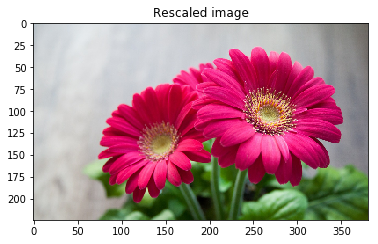

In [4]:
print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
print("Model's input shape is %dx%d") % (input_height, input_width)
aspect = img.shape[1]/float(img.shape[0])
print("Orginal aspect ratio: " + str(aspect))
if(aspect>1):
    # landscape orientation - wide image
    res = int(aspect * input_height)
    imgScaled = skimage.transform.resize(img, (input_width, res))
if(aspect<1):
    # portrait orientation - tall image
    res = int(input_width/aspect)
    imgScaled = skimage.transform.resize(img, (res, input_height))
if(aspect == 1):
    imgScaled = skimage.transform.resize(img, (input_width, input_height))
pyplot.figure()
pyplot.imshow(imgScaled)
pyplot.axis('on')
pyplot.title('Rescaled image')
print("New image shape:" + str(imgScaled.shape) + " in HWC")

At this point only one dimension is set to what the model's input requires. We still need to crop one side to make a square. 

### Cropping

There are a variety of strategies we could utilize. In fact, we could backpeddle and decide to do a center crop. So instead of scaling down to the smallest we could get on at least one side, we take a chunk out of the middle. If we had done that without scaling we would have ended up with just part of a flower pedal, so we still needed some resizing of the image.

Below we'll try a few strategies for cropping:

1. Just grab the exact dimensions you need from the middle!
2. Resize to a square that's pretty close then grab from the middle.
3. Use the rescaled image and grab the middle.

Original image shape:(751, 1280, 3) and remember it should be in H, W, C!


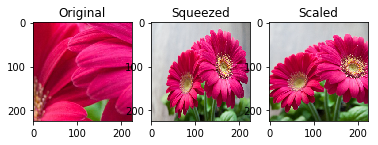

In [8]:
# Compare the images and cropping strategies
# Try a center crop on the original for giggles
print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]
# yes, the function above should match resize and take a tuple...

pyplot.figure()
# Original image
imgCenter = crop_center(img,224,224)
pyplot.subplot(1,3,1)
pyplot.imshow(imgCenter)
pyplot.axis('on')
pyplot.title('Original')

# Now let's see what this does on the distorted image
img256Center = crop_center(img256,224,224)
pyplot.subplot(1,3,2)
pyplot.imshow(img256Center)
pyplot.axis('on')
pyplot.title('Squeezed')

# Scaled image
imgScaledCenter = crop_center(imgScaled,224,224)
pyplot.subplot(1,3,3)
pyplot.imshow(imgScaledCenter)
pyplot.axis('on')
pyplot.title('Scaled')

As you can see that didn't work out so well, except for maybe the last one. The middle one may be just fine too, but you won't know until you try on the model and test a lot of candidate images.
At this point we can look at the difference we have, split it in half and remove some pixels from each side. This does have a drawback, however, as an off-center subject of interest would get clipped.

If you've run this tutorial a few times now and are on Round 3, you'll notice a pretty big problem. You're missing astronaughts! You can still see the issue with the flower from Round 2 as well. Things are missing after the cropping and that could cause you problems. Think of it this way: if you don't know how the model you're using was prepared then you don't know how to conform your images, so take care to test results! If the model used a lot of different aspect ratio images and just squeezed them to conform to a square then there's a good chance that over time and lots of samples it "learned" what things look like squeezed and can make a match. However, if you're looking for details like facial features and landmarks, or really nuanced elements in any image, this could be dangerous and error-prone. 

#### Further Strategies?

Another strategy would be to rescale to the best size you can, with real data, but then pad the rest of the image with information that you can safely ignore in your model. We'll save that for another tutorial though since you've been through enough here! 

### Upscaling

What do you do when the images you want to run are "tiny"? In our example we've been prepping for Input Images with the spec of 224x224. Consider this 128x128 image below.
![cells at 128x128](images/Cellsx128.png)
Now we're not talking about super-resolution or the CSI-effect where we can take blurry ATM photos and identify the tattoo an a perp's neck. Although, there are [some advances](https://github.com/david-gpu/srez) along these lines that deep learning has provided, and if you're reading this in time (before 3/1/17), go [check this out](https://developer.nvidia.com/zoom-enhance-magic-image-upscaling-using-deep-learning). What we want to do is simple, but, like cropping, it does have a variety of strategies you should consider.

The most basic approach is going from a small square to a bigger square and using the defauls skimage provides for you. This `resize` method defaults the interpolation order parameter to 1 which happens to be bi-linear if you even cared, but it is worth mentioning because these might be the fine-tuning knobs you need later to fix problems, such as strange visual artifacts, that can be introduced in upscaling images.

Original image shape:  (128, 128, 4)
Upscaled image shape:  (224, 224, 4)


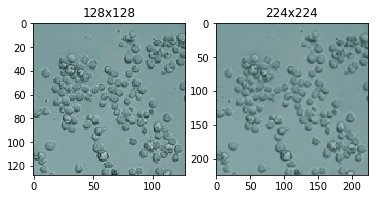

In [63]:
imgTiny = "images/Cellsx128.png"
imgTiny = skimage.img_as_float(skimage.io.imread(imgTiny)).astype(np.float32)
print "Original image shape: ", imgTiny.shape
imgTiny224 = skimage.transform.resize(imgTiny, (224, 224))
print "Upscaled image shape: ", imgTiny224.shape
# Plot original
pyplot.figure()
pyplot.subplot(1, 2, 1)
pyplot.imshow(imgTiny)
pyplot.axis('on')
pyplot.title('128x128')
# Plot upscaled
pyplot.subplot(1, 2, 2)
pyplot.imshow(imgTiny224)
pyplot.axis('on')
pyplot.title('224x224')

Great, it worked!. You can see in the shape outputs that you had (128, 128, 4) and you received (224, 224, 4). Wait a minute! 4? In every example so far the last value in shape has been 3! When we used a png file we entered a new reality; one where transparency is possible. This 4th value describes opacity, or transparency, depending if you're a half-glass-empty type. Anyway, we can handle it just fine, but keep an eye on that number.

It's appropriate to put this discussion towards the end, but before we do further manipulations to the image, it's data order, and its overall payload. You can really mess up your data and the image if you do a simple resample on the image in its current format. Remember that it is currently a cube of data and that there's more going on in there right now than just Red, Green, and Blue (and opacity). Depending on when you decide to resize you'll have to account for that extra data.

Let's break stuff! Try upscaling the image after you've switched the image to CHW.

Image shape before HWC --> CHW conversion:  (128, 128, 4)
Image shape after HWC --> CHW conversion:  (4, 128, 128)
Image shape after resize:  (224, 224, 128)
Here come bad things!


TypeError: Invalid dimensions for image data

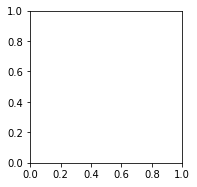

In [64]:
imgTiny = "images/Cellsx128.png"
imgTiny = skimage.img_as_float(skimage.io.imread(imgTiny)).astype(np.float32)
print "Image shape before HWC --> CHW conversion: ", imgTiny.shape
# swapping the axes to go from HWC to CHW
# uncomment the next line and run this block!
imgTiny = imgTiny.swapaxes(1, 2).swapaxes(0, 1)
print "Image shape after HWC --> CHW conversion: ", imgTiny.shape
imgTiny224 = skimage.transform.resize(imgTiny, (224, 224))
print "Image shape after resize: ", imgTiny224.shape
# we know this is going to go wrong, so...
try:
    # Plot original
    pyplot.figure()
    pyplot.subplot(1, 2, 1)
    pyplot.imshow(imgTiny)
    pyplot.axis('on')
    pyplot.title('128x128')
except:
    print "Here come bad things!"
    raise 

Epic fail, right? If you let the code block above swap the axes, then resize the image, you will see this output:

`Image shape after resize:  (224, 224, 128)`

Now you have 128 where you should still have 4. Oops. Let's revert in the code block below and try something else. We'll show an example where the image is smaller than your Input specification, and not square. Like maybe it came from a new microscope that can only take imagery in rectangular bands.

Slice image shape:  (56, 128, 4)
Upscaled slice image shape:  (224, 224, 4)


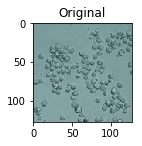

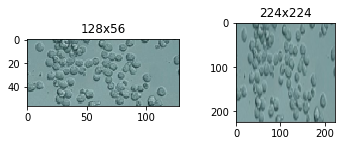

In [72]:
imgTiny = "images/Cellsx128.png"
imgTiny = skimage.img_as_float(skimage.io.imread(imgTiny)).astype(np.float32)
imgTinySlice = crop_center(imgTiny, 128, 56)
# Plot original
pyplot.figure()
pyplot.subplot(2, 1, 1)
pyplot.imshow(imgTiny)
pyplot.axis('on')
pyplot.title('Original')
# Plot slice
pyplot.figure()
pyplot.subplot(2, 2, 1)
pyplot.imshow(imgTinySlice)
pyplot.axis('on')
pyplot.title('128x56')
# Upscale?
print "Slice image shape: ", imgTinySlice.shape
imgTiny224 = skimage.transform.resize(imgTinySlice, (224, 224))
print "Upscaled slice image shape: ", imgTiny224.shape
# Plot upscaled
pyplot.subplot(2, 2, 2)
pyplot.imshow(imgTiny224)
pyplot.axis('on')
pyplot.title('224x224')

Alright, this was a bit of a stretch for an example of how upscaling can fail. Get it? Stretch? This could be a life-or-death kind of failure though. What if normal cells are circular and diseased cells are elongated and bent? Sickle cell anemia for example: 
![sickle cells example](https://upload.wikimedia.org/wikipedia/commons/4/4b/1911_Sickle_Cells.jpg)
In this situation, what do you do? It really depends on the model and how it was trained. In some cases it may be ok to pad the rest of the image with white, or maybe black, or maybe noise, or maybe even use png and transparencies and set a mask for the images so the model ignores transparent areas. See how much fun you can have figuring this out and you get to make medical breakthroughs too!

Let's move on to the last step which we've already mentioned and that is to adjust the image input to be in BGR order. There's also another feature that Caffe2 uses, which is a `batch term`.

### Final Preprocessing and the Batch Term

In the last steps below we are going to switch the image's data order to BGR and add a fourth dimension to the image. That's right, the 4th dimension! In theory, you can just keep adding dimensions to your data, and this one is somewhat important for Caffe2 as it relays to Caffe how many images to expect in this batch. We set it to one to indicate there's only one image going into Caffe in this batch. Note that in the final output when we check `img.shape` the order is quite different. We've added batch (called B here) and changed the order like so: `B, C, H, W`

Image shape before HWC --> CHW conversion:  (224, 224, 3)
Image shape after HWC --> CHW conversion:  (3, 224, 224)
Final input shape is: (1, 3, 224, 224)


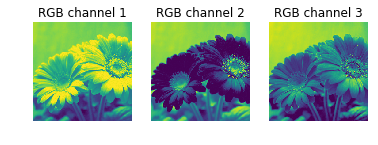

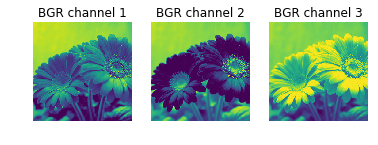

In [19]:
# this next line helps with being able to rerun this section
# if you want to try the outputs of the different crop strategies above
# swap out imgScaled with img (original) or img256 (squeezed)
imgCropped = crop_center(imgScaled,224,224)
print "Image shape before HWC --> CHW conversion: ", imgCropped.shape
# (1) Since Caffe expects CHW order and the current image is HWC,
#     we will need to change the order.
imgCropped = imgCropped.swapaxes(1, 2).swapaxes(0, 1)
print "Image shape after HWC --> CHW conversion: ", imgCropped.shape

pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(imgCropped[i])
    pyplot.axis('off')
    pyplot.title('RGB channel %d' % (i+1))

# (2) Caffe uses a BGR order due to legacy OpenCV issues, so we
#     will change RGB to BGR.
imgCropped = imgCropped[(2, 1, 0), :, :]

# Not doing this now... maybe later when it makes sense to introduce
# (3) We will subtract the mean image. Note that skimage loads
#     image in the [0, 1] range so we multiply the pixel values
#     first to get them into [0, 255].
#mean_file = os.path.join(CAFFE_ROOT, 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
#mean = np.load(mean_file).mean(1).mean(1)
#img = img * 255 - mean[:, np.newaxis, np.newaxis]
pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(imgCropped[i])
    pyplot.axis('off')
    pyplot.title('BGR channel %d' % (i+1))
# (4) finally, since caffe2 expect the input to have a batch term
#     so we can feed in multiple images, we will simply prepend a
#     batch dimension of size 1. Also, we will make sure image is
#     of type np.float32.
imgCropped = imgCropped[np.newaxis, :, :, :].astype(np.float32)
print 'Final input shape is:', imgCropped.shape

In the output above you should note these alterations:
1. Before and after of the HWC to CHW change. The 3, which is the number of color channels moved to the beginning.
2. In the pictures above you can see that the color order was switched too. RGB became BGR. Blue and Red switched places.
3. The final input shape, meaning the last change to the image was to add the batch field to the beginning, so that now you have (1, 3, 224, 224) for: 
    - 1 image in the batch, 
    - 3 color channels (in BGR), 
    - 224 height, 
    - 224 width.

## TODO:

Explain why the original resize process to get to 224 went to 256 first then cropped to 224 and still had skewed aspect ratio.

What about the mean image step (#3) in the last code block?

Show example of batch loading > 1 and what Caffe does about it.